#  Statistical Relational Learning with `pslpython`

Can we build a PSL model for *link prediction* to evaluate the annotations in a friend graph?

In [1]:
import kglab

namespaces = {
    "acq": "http://example.org/stuff/",
    "foaf": "http://xmlns.com/foaf/0.1/",
    "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
    }

kg = kglab.KnowledgeGraph(
    name = "LINQS simple acquaintance example for PSL",
    base_uri = "http://example.org/stuff/",
    language = "en",
    namespaces = namespaces,
    )

kg.load_ttl("acq.ttl")

In [2]:
VIS_STYLE = {
    "foaf": {
        "color": "orange",
        "size": 5,
    },
    "acq":{
        "color": "blue",
        "size": 30,
    },
}

g = kg.vis_pyvis(notebook=True, style=VIS_STYLE)
g.barnes_hut()
g.show("tmp.html")

In [3]:
kg.save_ttl("foo.ttl")

In [4]:
from pslpython.model import Model
from pslpython.partition import Partition
from pslpython.predicate import Predicate
from pslpython.rule import Rule

model = Model("simple acquaintances")

# add predicates
predicate = Predicate("Knows", closed=False, size=2)
model.add_predicate(predicate)

predicate = Predicate("Likes", closed=True, size=2)
model.add_predicate(predicate)

predicate = Predicate("Neighbors", closed=True, size=2)
model.add_predicate(predicate)

In [5]:
# add rules
model.add_rule(Rule("20: Neighbors(P1, L) & Neighbors(P2, L) & (P1 != P2) -> Knows(P1, P2) ^2"))
model.add_rule(Rule("5: Neighbors(P1, L1) & Neighbors(P2, L2) & (P1 != P2) & (L1 != L2) -> !Knows(P1, P2) ^2"))

model.add_rule(Rule("10: Likes(P1, L) & Likes(P2, L) & (P1 != P2) -> Knows(P1, P2) ^2"))

model.add_rule(Rule("5: Knows(P1, P2) & Knows(P2, P3) & (P1 != P3) -> Knows(P1, P3) ^2"))
model.add_rule(Rule("5: !Knows(P1, P2) ^2"))

model.add_rule(Rule("Knows(P1, P2) = Knows(P2, P1) ."))

In [6]:
# reset the PSL network data
for predicate in model.get_predicates().values():
    predicate.clear_data()

In [7]:
def get_person_id (url):
    return url.replace("http://example.org/stuff/person_", "")

In [8]:
predicate = model.get_predicate("Neighbors")

query = """
SELECT DISTINCT ?p1 ?p2
  WHERE {
      ?p1 foaf:based_near ?l .
      ?p2 foaf:based_near ?l .
  }
        """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])

    if p1 != p2:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2])

In [9]:
predicate = model.get_predicate("Likes")
    
query = """
SELECT DISTINCT ?p1 ?p2
  WHERE {
      ?p1 foaf:topic_interest ?t .
      ?p2 foaf:topic_interest ?t .
  }
        """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])

    if p1 != p2:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2])

In [10]:
predicate = model.get_predicate("Likes")
predicate.__dict__

{'_types': [<ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>,
  <ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>],
 '_data': {<Partition.OBSERVATIONS: 'observations'>:       0   1    2
  0    12   2  1.0
  1    12   0  1.0
  2    12  10  1.0
  3    12   7  1.0
  4    12   4  1.0
  ..   ..  ..  ...
  567  13   4  1.0
  568   5   1  1.0
  569   5  21  1.0
  570   5   6  1.0
  571   4   6  1.0
  
  [572 rows x 3 columns],
  <Partition.TARGETS: 'targets'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: [],
  <Partition.TRUTH: 'truth'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: []},
 '_name': 'LIKES',
 '_closed': True}

In [11]:
import csv
import pandas as pd
import rdflib as rdf

targets = []
rows_list = []
predicate = model.get_predicate("Knows")

with open("dat/psl/knows_targets.txt", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    
    for i, row in enumerate(reader):
        p1, p2 = row
        targets.append((p1, p2))
    
        p1_url = rdf.URIRef("http://example.org/stuff/person_" + p1)
        p2_url = rdf.URIRef("http://example.org/stuff/person_" + p2)
        
        if (p1_url, kg.get_ns("foaf").knows, p2_url) in kg._g:
            truth = 1.0
            predicate.add_data_row(Partition.TRUTH, [p1, p2], truth_value=truth)
            predicate.add_data_row(Partition.TARGETS, [p1, p2])
            rows_list.append({ 0: p1, 1: p2, "truth": truth})
        elif (p1_url, kg.get_ns("acq").wantsIntro, p2_url) in kg._g:
            truth = 0.0
            predicate.add_data_row(Partition.TRUTH, [p1, p2], truth_value=truth)
            predicate.add_data_row(Partition.TARGETS, [p1, p2])
            rows_list.append({ 0: p1, 1: p2, "truth": truth})
        else:
            print("UNKNOWN", p1, p2)

df_dat = pd.DataFrame(rows_list)   

In [12]:
predicate = model.get_predicate("Knows")

query = """
SELECT ?p1 ?p2
  WHERE {
      ?p1 foaf:knows ?p2 .
  }
  ORDER BY ?p1 ?p2
        """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])
    
    if (p1, p2) not in targets:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2], truth_value=1.0)
    
query = """
SELECT ?p1 ?p2
  WHERE {
      ?p1 acq:wantsIntro ?p2 .
  }
  ORDER BY ?p1 ?p2
        """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])
    
    if (p1, p2) not in targets:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2], truth_value=0.0)

In [13]:
# inference

PSL_OPTIONS = {
    "log4j.threshold": "INFO"
}

results = model.infer(additional_cli_optons=[], psl_config=PSL_OPTIONS)

7475 [pslpython.model PSL] INFO --- 0    [main] INFO  org.linqs.psl.cli.Launcher  - Running PSL CLI Version 2.2.2-5f9a472
7782 [pslpython.model PSL] INFO --- 309  [main] INFO  org.linqs.psl.cli.Launcher  - Loading data
8083 [pslpython.model PSL] INFO --- 610  [main] INFO  org.linqs.psl.cli.Launcher  - Data loading complete
8084 [pslpython.model PSL] INFO --- 610  [main] INFO  org.linqs.psl.cli.Launcher  - Loading model from /var/folders/zz/2ffrqd5j7n52x67qd94h_r_h0000gp/T/psl-python/simple acquaintances/simple acquaintances.psl
8236 [pslpython.model PSL] INFO --- 762  [main] INFO  org.linqs.psl.cli.Launcher  - Model loading complete
8237 [pslpython.model PSL] INFO --- 763  [main] INFO  org.linqs.psl.cli.Launcher  - Starting inference with class: org.linqs.psl.application.inference.MPEInference
8439 [pslpython.model PSL] INFO --- 966  [main] INFO  org.linqs.psl.application.inference.MPEInference  - Grounding out model.
15009 [pslpython.model PSL] INFO --- 7536 [main] INFO  org.linqs.psl

In [14]:
# report results
predicate = model.get_predicates()["KNOWS"]
df = results[predicate]

df

,0,1,truth
0,7,20,0.002999
1,8,13,0.983527
2,8,12,0.980395
3,8,10,0.986561
4,8,21,0.977004
...,...,...,...
113,5,9,0.256435
114,5,7,0.245458
115,6,7,0.991628
116,6,9,0.235496


In [15]:
dat_val = {}

for index, row in df_dat.iterrows():
    p1 = row[0]
    p2 = row[1]
    key = (int(p1), int(p2))
    dat_val[key] = row["truth"]

for index, row in df.iterrows():
    p1 = row[0]
    p2 = row[1]
    key = (int(p1), int(p2))
    df.at[index, "diff"] = row["truth"] - dat_val[key]

df

,0,1,truth,diff
0,7,20,0.002999,0.002999
1,8,13,0.983527,-0.016473
2,8,12,0.980395,-0.019605
3,8,10,0.986561,-0.013439
4,8,21,0.977004,-0.022996
...,...,...,...,...
113,5,9,0.256435,-0.743565
114,5,7,0.245458,-0.754542
115,6,7,0.991628,-0.008372
116,6,9,0.235496,0.235496


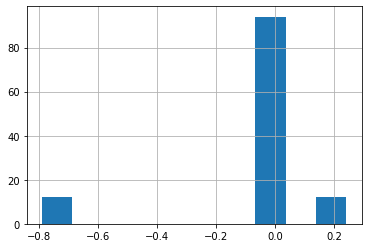

In [16]:
df["diff"].hist()

The following rows show where `foaf:knows` annotations in the graph differs significantly from its truth value predicted by PSL:

In [17]:
for index, row in df.iterrows():
    p1 = row[0]
    p2 = row[1]
    diff = row["diff"]
    
    if diff < -0.2:
        print("?? acq:person_{} foaf:knows acq:person_{}".format(int(row[0]), int(row[1])))

?? acq:person_21 foaf:knows acq:person_12
?? acq:person_21 foaf:knows acq:person_22
?? acq:person_22 foaf:knows acq:person_21
?? acq:person_5 foaf:knows acq:person_22
?? acq:person_6 foaf:knows acq:person_12
?? acq:person_12 foaf:knows acq:person_6
?? acq:person_7 foaf:knows acq:person_5
?? acq:person_9 foaf:knows acq:person_5
?? acq:person_12 foaf:knows acq:person_21
?? acq:person_22 foaf:knows acq:person_5
?? acq:person_5 foaf:knows acq:person_9
?? acq:person_5 foaf:knows acq:person_7
